In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import seaborn as sns
import pickle

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
mm = mydict['m']

### classifier - generated with maxp/shape/entropy features

In [3]:
mm.run.max()

9

In [4]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [5]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

14

In [6]:
mm.shape

(12790322, 20)

In [9]:
%%time

mmg = mm[mm.segment=='generated']

df_logitlens_kl_expanded = mmg['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded.shape[1])]

df_logitlens_iou_expanded = mmg['logitlens_iou'].apply(pd.Series)
df_logitlens_iou_expanded.columns = [f'logitlens_iou{i}' for i in range(df_logitlens_iou_expanded.shape[1])]

# concat with the original
mmg = pd.concat([mmg.drop(columns=['logitlens_kl', 'logitlens_iou']),
                     df_logitlens_kl_expanded,
                     df_logitlens_iou_expanded], axis=1)

CPU times: user 15.6 s, sys: 238 ms, total: 15.9 s
Wall time: 16 s


In [10]:
mmg.shape

(130532, 82)

In [11]:
%%time

# beginning of generation
N = 10

selected_features = ['shape', 'true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

CPU times: user 22.7 ms, sys: 8.88 ms, total: 31.6 ms
Wall time: 39.3 ms


In [12]:
ds.correct.value_counts()

correct
True     3668
False    1422
Name: count, dtype: int64

In [13]:
ds.shape

(5090, 34)

In [14]:
# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-2])

In [15]:
ds.shape

(750, 34)

In [16]:
y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

In [17]:
X.loc[:,X.nunique()!=1].shape

(750, 29)

In [18]:
X.isnull().sum().sum() == 0

True

In [19]:
# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_generated = y_res

X_res.columns = ['generated_'+col for col in X.columns]

In [20]:
X_res.isnull().sum().sum() == 0

True

### beginning of generation

In [21]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X, y, cv=GroupKFold(n_splits=10), groups=pids)
# pred_proba = cross_val_predict(xgb_model, X, y, cv=LeaveOneGroupOut(), groups=pids, method='predict_proba')

pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 6.06 s, sys: 2.05 s, total: 8.11 s
Wall time: 1.14 s


In [22]:
pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.66      0.65      0.66       315
        True       0.75      0.75      0.75       435

    accuracy                           0.71       750
   macro avg       0.70      0.70      0.70       750
weighted avg       0.71      0.71      0.71       750



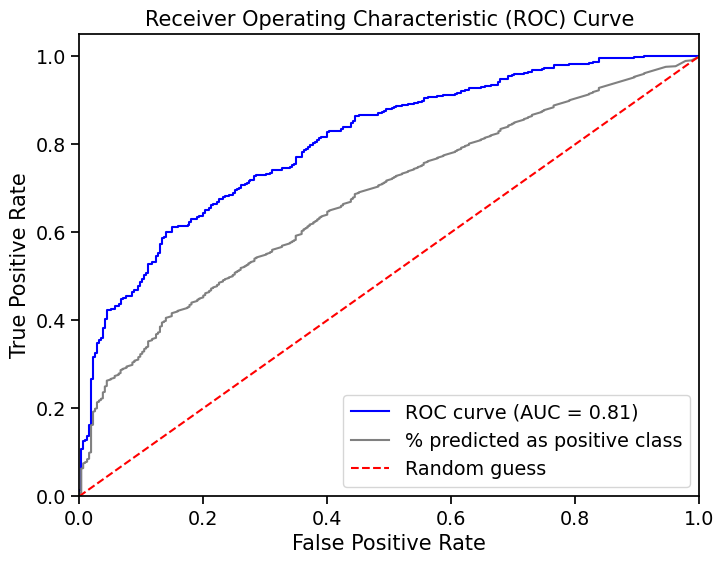

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / len(y_res.values) for thr in thresholds]

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='grey', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
%%time

import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 4.66 s, sys: 703 ms, total: 5.36 s
Wall time: 2.4 s


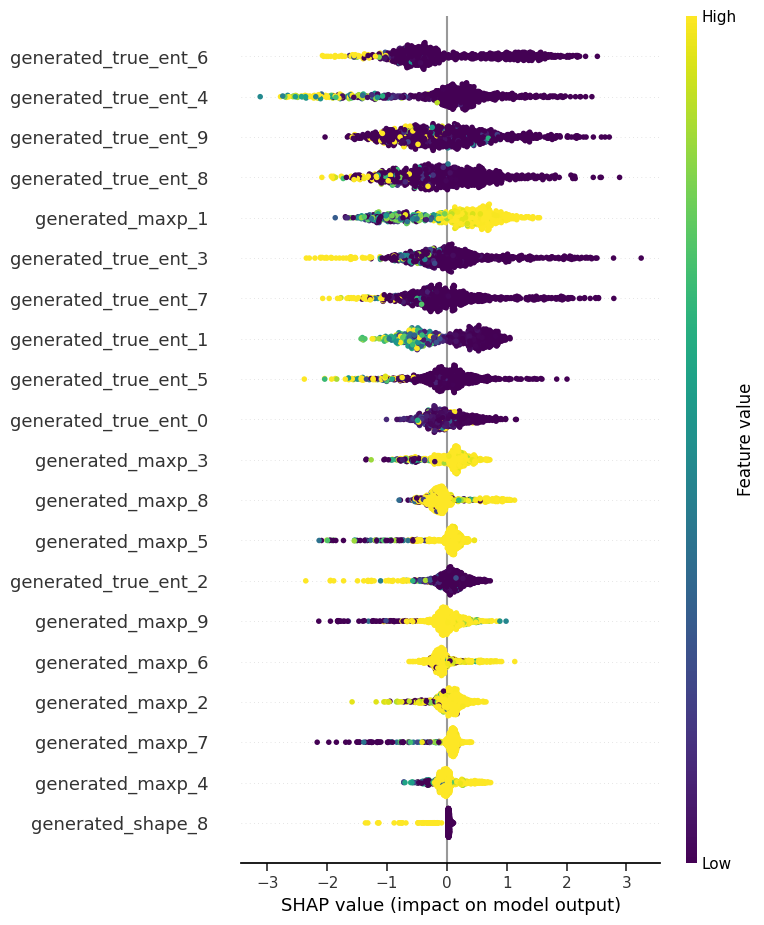

In [25]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [26]:
# shap.plots.heatmap(shap_values, cmap="RdBu_r")

In [27]:
#clustering = shap.utils.hclust(X_res, y_res)
#shap.plots.bar(shap_values, clustering=clustering, max_display=20, clustering_cutoff=1)

In [28]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [29]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.296434
generated_shape_       0.011195
generated_true_ent_    0.692370
Name: value, dtype: float64

In [30]:
K = 10
top_feat_generated_begin = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()

In [31]:
vals

,label,value,label_orig,grp
16,6,0.102801,generated_true_ent_6,generated_true_ent_
14,4,0.091906,generated_true_ent_4,generated_true_ent_
19,9,0.084607,generated_true_ent_9,generated_true_ent_
18,8,0.081996,generated_true_ent_8,generated_true_ent_
21,1,0.080366,generated_maxp_1,generated_maxp_
13,3,0.075543,generated_true_ent_3,generated_true_ent_
17,7,0.073732,generated_true_ent_7,generated_true_ent_
11,1,0.067472,generated_true_ent_1,generated_true_ent_
15,5,0.050700,generated_true_ent_5,generated_true_ent_
10,0,0.034202,generated_true_ent_0,generated_true_ent_




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

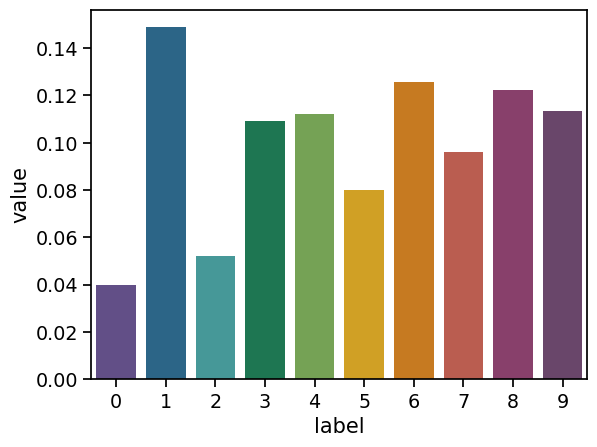

In [32]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(27.44444444444443, 0.5, 'Token index')

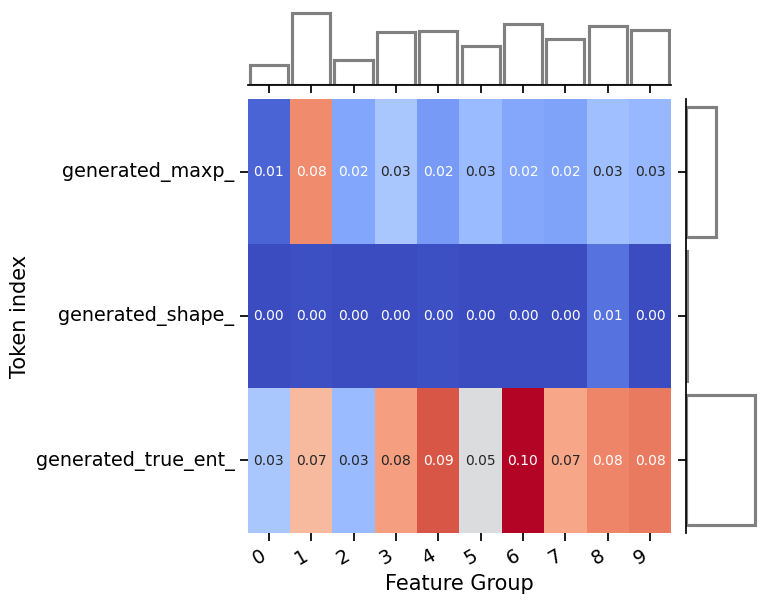

In [33]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### generated with all features

In [37]:
%%time

# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns) + list(df_logitlens_iou_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-2])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_generated = y_res

X_res.columns = ['generated_'+col for col in X.columns]

CPU times: user 84 ms, sys: 21.5 ms, total: 106 ms
Wall time: 105 ms


In [38]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba_all = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 1min 57s, sys: 8.21 s, total: 2min 5s
Wall time: 20.2 s


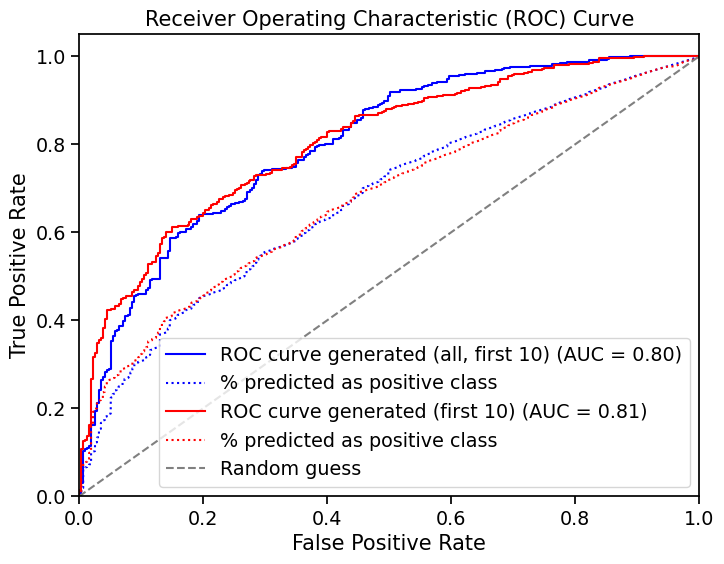

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_all[:, 1])
true_counts_rel = [(pred_proba_all[:, 1] > thr).sum() / pred_proba_all.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve generated (all, first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [40]:
%%time

import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

vals.groupby('grp').value.sum()

CPU times: user 10.5 s, sys: 865 ms, total: 11.4 s
Wall time: 2.73 s


grp
generated_logitlens_iou_    0.403633
generated_logitlens_kl_     0.462353
generated_maxp_             0.043456
generated_true_ent_         0.090558
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

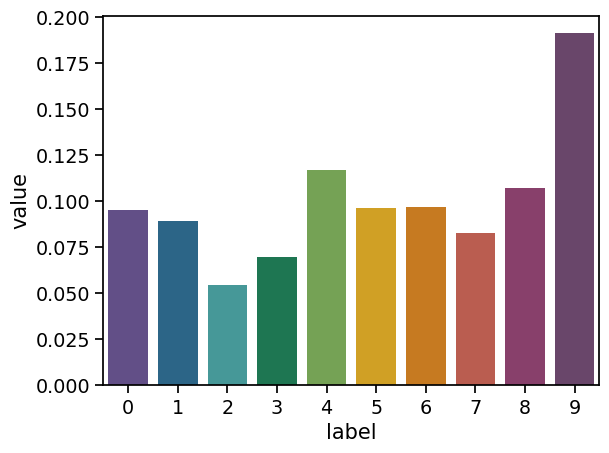

In [41]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(27.44444444444443, 0.5, 'Token index')

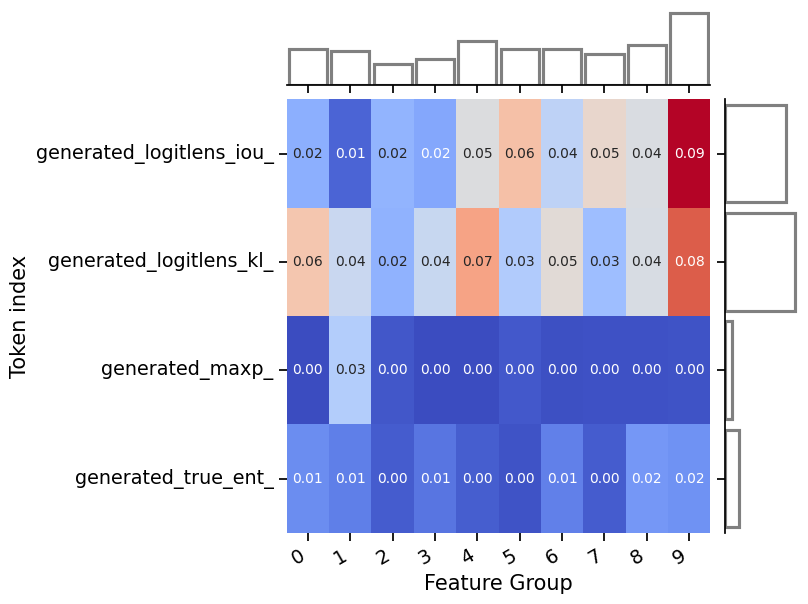

In [42]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### only kl

In [135]:
%%time

# beginning of generation
N = 10

selected_features = list(df_logitlens_kl_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-2])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_generated = y_res

X_res.columns = ['generated_'+col for col in X.columns]

CPU times: user 49.4 ms, sys: 61.4 ms, total: 111 ms
Wall time: 286 ms


In [136]:
import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [137]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

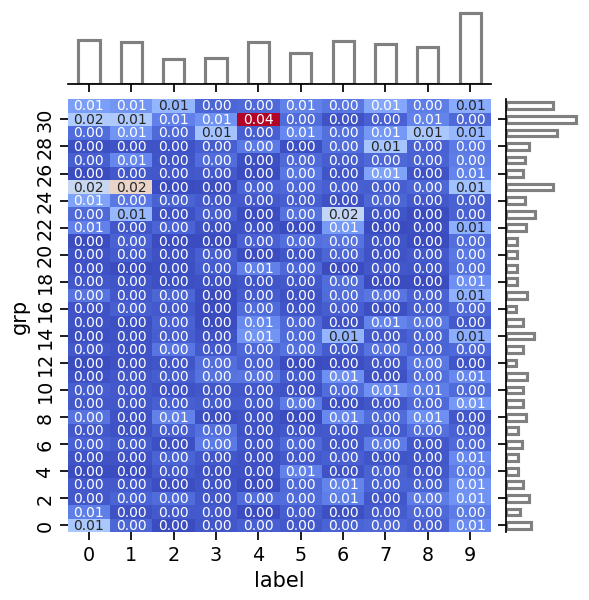

In [138]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 10)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 32)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

### postilla

In [44]:
mm[(mm.segment=='postilla')].tokzero.max()

64

In [45]:
# end of ...
# ds = mm[(mm.segment=='postilla') & (mm.tokzero_end>=-10)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates
ds = ds.drop_duplicates(ds.columns[1:-2])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]
y_res_postilla = y_res

X_res.columns = ['postilla_'+col for col in X.columns]

In [46]:
ds

,run,pid,shape-65,shape-64,shape-63,shape-62,shape-61,shape-60,shape-59,shape-58,shape-57,shape-56,shape-55,shape-54,shape-53,shape-52,shape-51,shape-50,shape-49,shape-48,shape-47,shape-46,shape-45,shape-44,shape-43,shape-42,shape-41,shape-40,shape-39,shape-38,shape-37,shape-36,shape-35,shape-34,shape-33,shape-32,shape-31,shape-30,shape-29,shape-28,shape-27,shape-26,shape-25,shape-24,shape-23,shape-22,shape-21,shape-20,shape-19,shape-18,shape-17,shape-16,shape-15,shape-14,shape-13,shape-12,shape-11,shape-10,shape-9,shape-8,shape-7,shape-6,shape-5,shape-4,shape-3,shape-2,shape-1,maxp-65,maxp-64,maxp-63,maxp-62,maxp-61,maxp-60,maxp-59,maxp-58,maxp-57,maxp-56,maxp-55,maxp-54,maxp-53,maxp-52,maxp-51,maxp-50,maxp-49,maxp-48,maxp-47,maxp-46,maxp-45,maxp-44,maxp-43,maxp-42,maxp-41,maxp-40,maxp-39,maxp-38,maxp-37,maxp-36,maxp-35,maxp-34,maxp-33,maxp-32,maxp-31,maxp-30,maxp-29,maxp-28,maxp-27,maxp-26,maxp-25,maxp-24,maxp-23,maxp-22,maxp-21,maxp-20,maxp-19,maxp-18,maxp-17,maxp-16,maxp-15,maxp-14,maxp-13,maxp-12,maxp-11,maxp-10,maxp-9,maxp-8,maxp-7,maxp-6,maxp-5,maxp-4,maxp-3,maxp-2,maxp-1,true_ent-65,true_ent-64,true_ent-63,true_ent-62,true_ent-61,true_ent-60,true_ent-59,true_ent-58,true_ent-57,true_ent-56,true_ent-55,true_ent-54,true_ent-53,true_ent-52,true_ent-51,true_ent-50,true_ent-49,true_ent-48,true_ent-47,true_ent-46,true_ent-45,true_ent-44,true_ent-43,true_ent-42,true_ent-41,true_ent-40,true_ent-39,true_ent-38,true_ent-37,true_ent-36,true_ent-35,true_ent-34,true_ent-33,true_ent-32,true_ent-31,true_ent-30,true_ent-29,true_ent-28,true_ent-27,true_ent-26,true_ent-25,true_ent-24,true_ent-23,true_ent-22,true_ent-21,true_ent-20,true_ent-19,true_ent-18,true_ent-17,true_ent-16,true_ent-15,true_ent-14,true_ent-13,true_ent-12,true_ent-11,true_ent-10,true_ent-9,true_ent-8,true_ent-7,true_ent-6,true_ent-5,true_ent-4,true_ent-3,true_ent-2,true_ent-1,correct,hallucinated
0,0,12,5.0,5.0,19.0,14.0,8.0,3.0,3.0,96.0,6.0,1.0,3.0,1.0,4.0,5.0,11.0,149.0,2.0,3.0,1.0,15.0,2.0,2.0,1.0,27.0,6.0,1.0,1.0,2.0,1.0,7.0,3.0,1.0,19.0,4.0,1.0,2.0,1.0,1.0,1.0,3.0,71.0,1.0,1.0,12.0,15.0,1.0,8.0,52.0,4.0,2.0,1.0,2.0,37.0,153.0,1.0,1.0,5.0,14.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.512207,0.420410,0.454590,0.297119,0.392090,0.746582,0.791504,0.248413,0.604492,0.999512,0.519043,0.956543,0.723633,0.417236,0.224487,0.091614,0.699707,0.846191,0.960938,0.320068,0.795410,0.844238,0.900879,0.252441,0.305420,0.998535,1.0,0.887695,0.996582,0.641602,0.641602,0.925293,0.381104,0.580078,0.999512,0.705566,0.908691,0.991699,0.991699,0.808594,0.331299,0.956543,0.986816,0.630859,0.424072,0.907715,0.255127,0.212280,0.634766,0.757324,1.0,0.769043,0.404297,0.469971,0.911133,1.0,0.760742,0.319824,0.999512,0.945312,0.957520,1.0,0.926758,1.0,1.0,1.783120,1.732312,2.561607,2.549820,1.851384,1.010655,1.152412,3.701926,1.628087,0.004159,1.106275,0.289020,1.109412,1.731305,2.554809,4.651467,0.786097,0.732444,0.232670,2.466945,0.562495,0.776645,0.609743,2.794227,2.071790,0.013476,0.000024,0.517225,0.034213,1.647491,1.143655,0.342328,2.568987,1.213702,0.003429,1.037942,0.533992,0.055744,0.059261,0.841475,3.378552,0.233909,0.085822,1.931323,2.451367,0.394635,2.304712,3.416368,1.315588,0.557634,0.000012,0.631560,2.903704,3.365449,0.310922,0.000173,1.358079,2.591903,0.005839,0.318298,0.256653,0.000155,0.285100,0.000010,0.000000,False,False
1,0,14,14.0,5.0,31.0,14.0,7.0,1.0,7.0,26.0,5.0,1.0,3.0,1.0,4.0,5.0,9.0,111.0,2.0,4.0,1.0,33.0,2.0,1.0,2.0,35.0,6.0,1.0,1.0,1.0,1.0,8.0,3.0,1.0,12.0,3.0,1.0,2.0,1.0,1.0,1.0,3.0,56.0,2.0,1.0,23.0,26.0,2.0,8.0,45.0,2.0,2.0,1.0,1.0,17.0,123.0,2.0,1.0,4.0,15.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.286377,0.470703,0.295410,0.346436,0.411133,0.941895,0.754883,0.318359,0.639160,1.000000,0.455078,0.950195,0.427002,0.544434,0.323975,0.163574,0.668945,0.488281,0.922363,0.178833,0.826172,0.987793,0.873535,0.362793,0.414307,0.999023,1.0,0.935059,0.991211,0.696289,0.582520,0.916504,0.240601,0.616699,0.999512,0.781250,0.909180,0.980957,0.978516,0.692871,0.269531,0.893555,0.982422,0.526367,0

In [47]:
y_res_postilla.shape, y_res_generated.shape

((509,), (750,))

In [48]:
%%time

class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_postilla = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                                     groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

CPU times: user 20.1 s, sys: 1.33 s, total: 21.4 s
Wall time: 2.8 s


In [49]:
pred = pred_proba_postilla.argmax(axis=1).astype(bool)
print(classification_report(y_res_postilla.values, pred))

              precision    recall  f1-score   support

       False       0.40      0.38      0.39       143
        True       0.76      0.78      0.77       366

    accuracy                           0.67       509
   macro avg       0.58      0.58      0.58       509
weighted avg       0.66      0.67      0.66       509



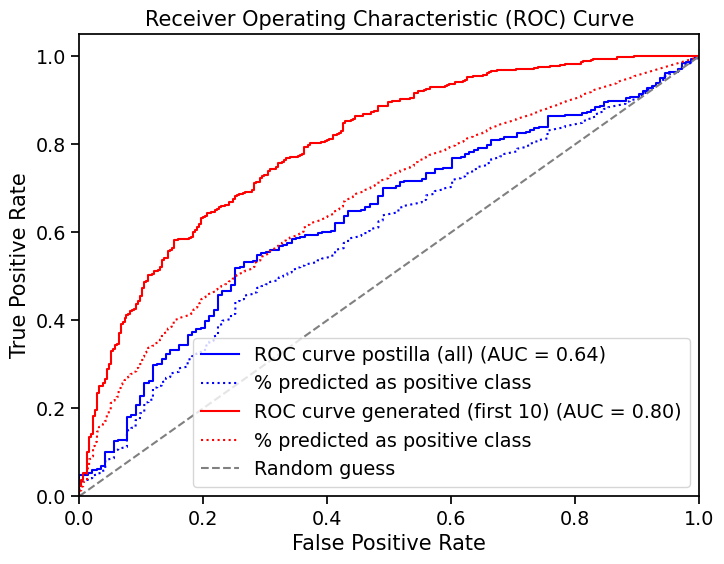

In [50]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res_postilla.values, pred_proba_postilla[:, 1])
true_counts_rel = [(pred_proba_postilla[:, 1] > thr).sum() / pred_proba_postilla.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [51]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

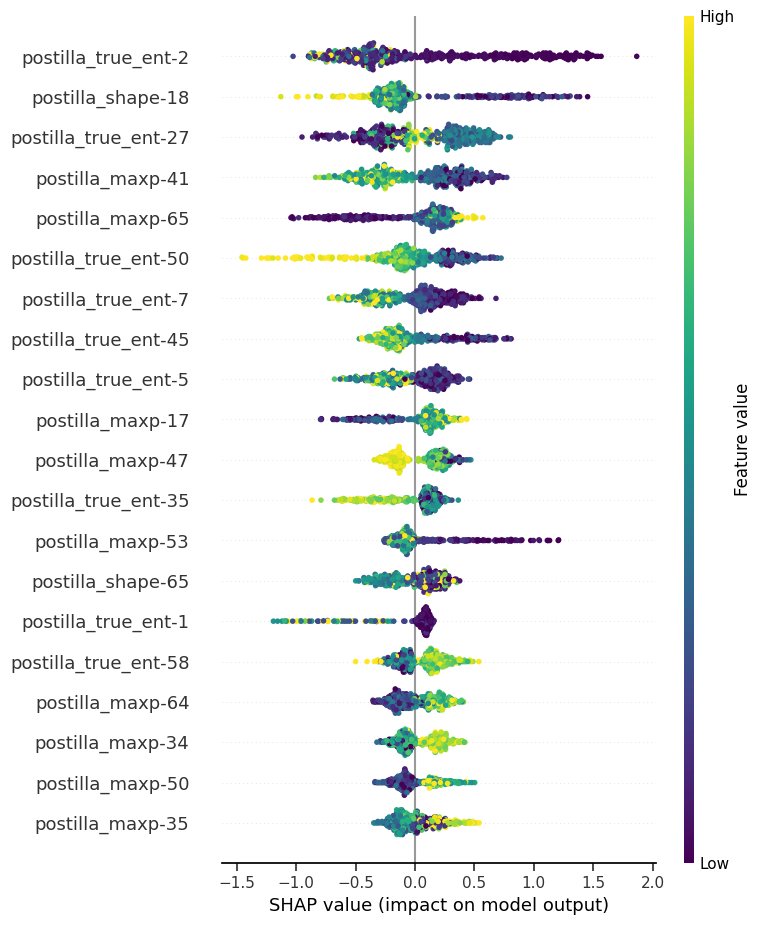

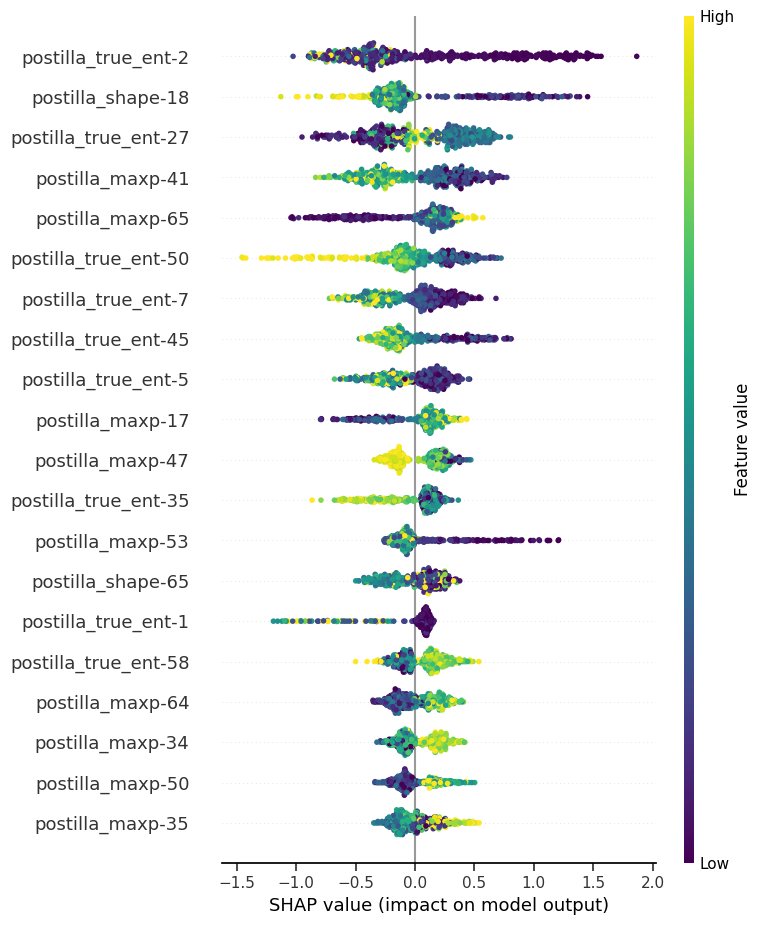

In [52]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [53]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [54]:
K = 10
top_feat_postilla_all = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()

In [55]:
vals.sort_values('value', ascending=False)[:K].value.sum()

0.27338602819637803

In [56]:
vals.groupby('grp').value.sum()

grp
postilla_maxp-        0.414988
postilla_shape-       0.108978
postilla_true_ent-    0.476034
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



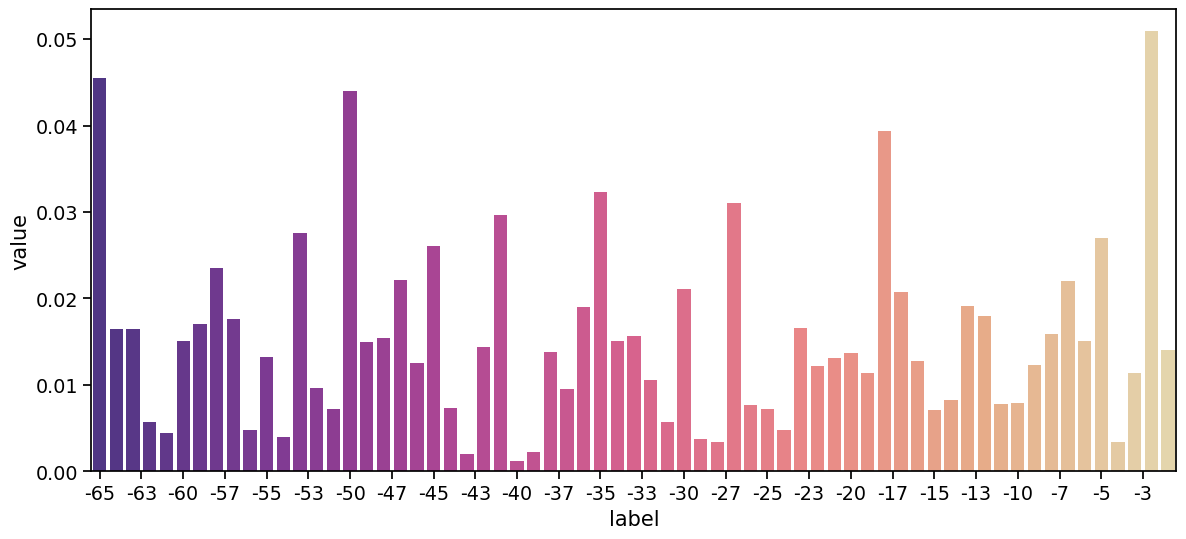

In [57]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

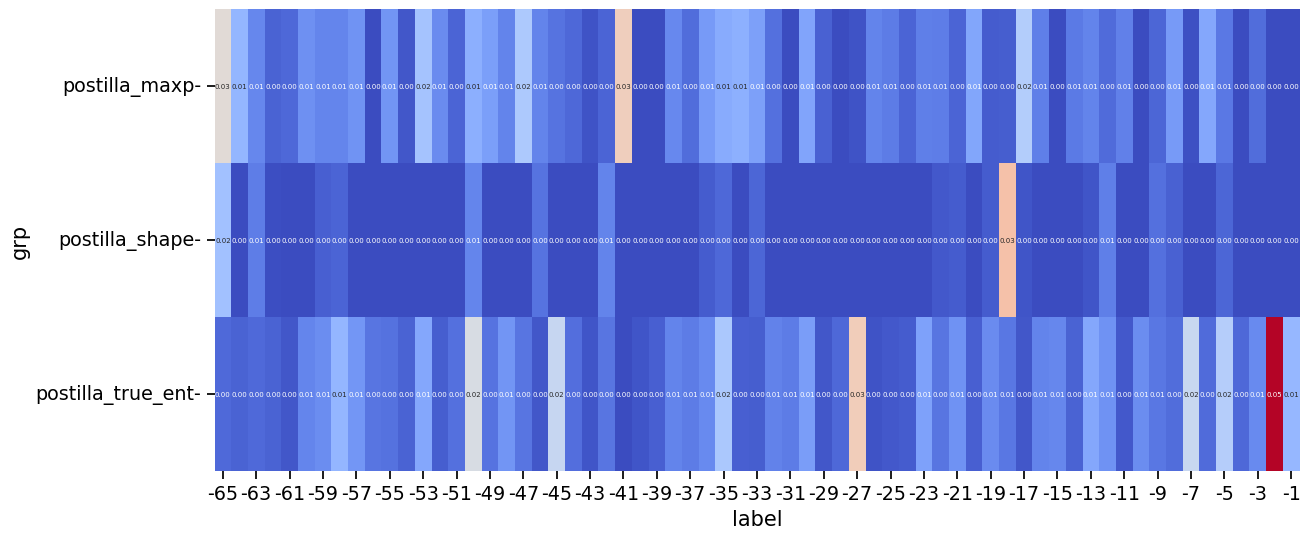

In [58]:
plt.figure(figsize=(14, 6))
_toplot = vals.pivot(index='grp', columns='label', values='value')
ax = plt.gca()
sns.heatmap(_toplot, ax=ax, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":5}, cmap="coolwarm")
plt.show()

### combo

In [74]:
# COMBO
# beginning of generate + postilla

ds = mm[(mm.segment=='generated') & (mm.tokzero<=N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds1 = ds.merge(truth, on=['run', 'pid'])
ds1.columns = ['generated_' + col if col[-1].isdigit() else col for col in ds1.columns]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds2 = ds.merge(truth, on=['run', 'pid'])
ds2.columns = ['postilla_' + col if col[-1].isdigit() else col for col in ds2.columns]

In [75]:
ds = ds1.merge(ds2, on = ['run', 'pid', 'correct', 'hallucinated'])

In [76]:
ds.shape, ds1.shape, ds2.shape

((5090, 232), (5090, 37), (5090, 199))

In [77]:
y = ds.correct
pids = ds.pid

X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# SELECT TOP FEATURES ONLY
X = X[top_feat_postilla_all + top_feat_generated_begin]

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

In [78]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
pred_proba_combo = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 5.97 s, sys: 357 ms, total: 6.32 s
Wall time: 813 ms


In [79]:
pred = pred_proba_combo.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.64      0.53      0.58      1422
        True       0.60      0.70      0.65      1422

    accuracy                           0.62      2844
   macro avg       0.62      0.62      0.61      2844
weighted avg       0.62      0.62      0.61      2844



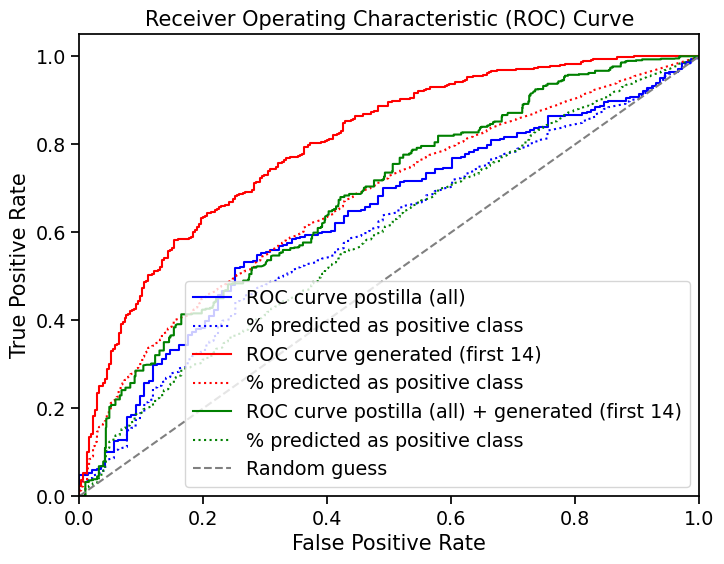

In [80]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

fpr, tpr, thresholds = roc_curve(y_res_postilla.values, pred_proba_postilla[:, 1])
true_counts_rel = [(pred_proba_postilla[:, 1] > thr).sum() / pred_proba_postilla.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all)')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first 14)')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_combo[:, 1])
true_counts_rel = [(pred_proba_combo[:, 1] > thr).sum() / pred_proba_combo.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='green', label=f'ROC curve postilla (all) + generated (first 14)')
plt.plot(fpr, true_counts_rel, color='green', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [88]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

 98%|===================| 3735/3806 [00:13<00:00]        

In [89]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [90]:
vals.groupby('grp').value.sum()

grp
generated_maxp        0.159653
generated_true_ent    0.578917
postilla_maxp-        0.109710
postilla_true_ent-    0.151719
Name: value, dtype: float64

In [91]:
vals

,label,value,label_orig,grp
11,6,0.109513,generated_true_ent6,generated_true_ent
10,4,0.104805,generated_true_ent4,generated_true_ent
12,1,0.082474,generated_true_ent1,generated_true_ent
19,8,0.080972,generated_true_ent8,generated_true_ent
18,11,0.071231,generated_true_ent11,generated_true_ent
13,7,0.067407,generated_true_ent7,generated_true_ent
16,9,0.062517,generated_true_ent9,generated_true_ent
17,5,0.056003,generated_maxp5,generated_maxp
14,3,0.055498,generated_maxp3,generated_maxp
15,1,0.048152,generated_maxp1,generated_maxp




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

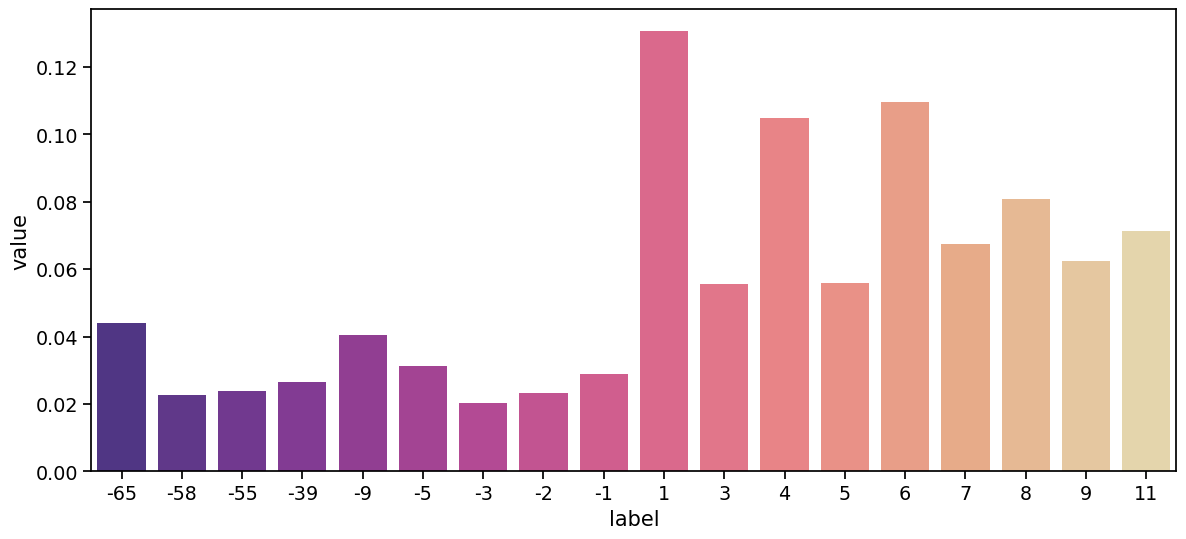

In [92]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

# ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

Text(27.44444444444443, 0.5, 'Token index')

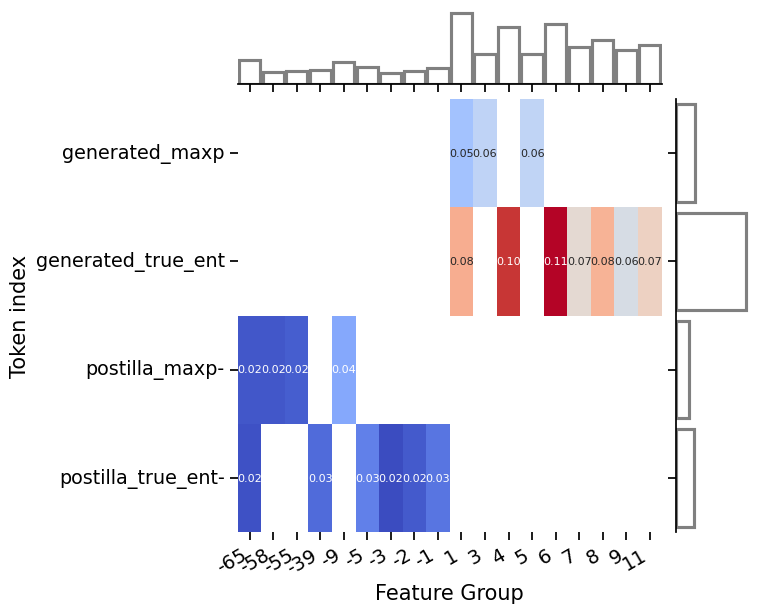

In [94]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":8}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### end of input (no candidates provided yet)

In [82]:
# end of input (last NN)
NN = 64
ds = mm[(mm.segment=='input') & (mm.tokzero_end>=-NN)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

X_res.columns = ['input_'+col for col in X.columns]

In [83]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_input = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

pred = pred_proba_input.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.53      0.32      0.40      1422
        True       0.51      0.71      0.59      1422

    accuracy                           0.52      2844
   macro avg       0.52      0.52      0.50      2844
weighted avg       0.52      0.52      0.50      2844

CPU times: user 26.7 s, sys: 2.57 s, total: 29.3 s
Wall time: 4.16 s


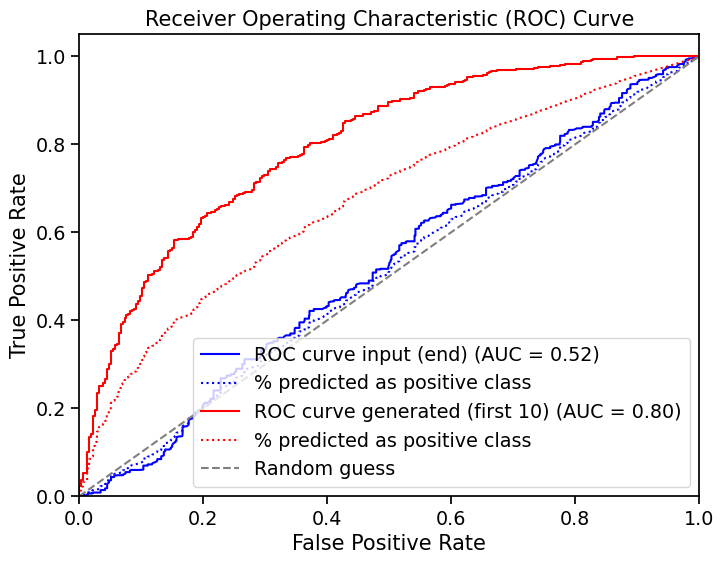

In [84]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_input[:, 1])
true_counts_rel = [(pred_proba_input[:, 1] > thr).sum() / pred_proba_input.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve input (end) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res_generated.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### does adding candidate distance measures add information?

In [96]:
# candidate measures are known at runtime and constant for each prompt

In [97]:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

In [98]:
N = 2
#ds = mm[(mm.segment=='generated') & (mm.tokzero<N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

ds = ds[ds.pid.isin(aggrodue.pid.unique())] # something got lost on the way?

In [99]:
# % of prompts showing variance in output across runs (selected features)
(ds.groupby('pid').std() != 0.).sum() / ds.pid.nunique()

run             1.000000
maxp0           0.000000
maxp1           0.000000
maxp2           0.000000
maxp3           0.000000
                  ...   
true_ent62      0.000000
true_ent63      0.000000
true_ent64      0.000000
correct         0.354379
hallucinated    0.014257
Length: 133, dtype: float64

In [100]:
# WARNING only unique observations
ds = ds.drop_duplicates(ds.columns[1:-2])

In [101]:
ds.shape

(491, 134)

In [102]:
ds.correct.value_counts()

correct
True     349
False    142
Name: count, dtype: int64

In [103]:
# check variances

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'hallucinated'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y #rus.fit_resample(X, y)

In [104]:
X_res.shape

(491, 132)

In [105]:
y_res.value_counts()

correct
True     349
False    142
Name: count, dtype: int64

In [106]:
(X_res.groupby('pid').std() != 0.).sum() / X_res.pid.nunique()

maxp0         1.0
maxp1         1.0
maxp2         1.0
maxp3         1.0
maxp4         1.0
             ... 
true_ent61    1.0
true_ent62    1.0
true_ent63    1.0
true_ent64    1.0
correct       1.0
Length: 131, dtype: float64

In [107]:
# dataset 

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

print(X.shape, y.sum())

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]
X_res.columns

(491, 130) 349


Index(['generated_maxp0', 'generated_maxp1', 'generated_maxp2',
       'generated_maxp3', 'generated_maxp4', 'generated_maxp5',
       'generated_maxp6', 'generated_maxp7', 'generated_maxp8',
       'generated_maxp9',
       ...
       'generated_true_ent55', 'generated_true_ent56', 'generated_true_ent57',
       'generated_true_ent58', 'generated_true_ent59', 'generated_true_ent60',
       'generated_true_ent61', 'generated_true_ent62', 'generated_true_ent63',
       'generated_true_ent64'],
      dtype='object', length=130)

In [108]:
X_res.shape, y_res.shape

((491, 130), (491,))

In [109]:
# class weights
class_counts = np.bincount(y_res)
class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
sample_weights = np.array([class_weights[y] for y in y_res])

In [110]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.43      0.35      0.38       142
        True       0.75      0.82      0.78       349

    accuracy                           0.68       491
   macro avg       0.59      0.58      0.58       491
weighted avg       0.66      0.68      0.67       491

CPU times: user 17.4 s, sys: 1.55 s, total: 18.9 s
Wall time: 2.44 s


In [111]:
# dataset with candidate measures

add = aggrodue[['pid', 'cand_average_dist_mean', 'cand_max_dist_mean', 'cand_average_jaccard_dist_mean', 'cand_average_jaccard_tok_dist_mean']]
add = add.rename(columns={'cand_average_dist_mean': 'cand_average_dist_mean999', 
                          'cand_max_dist_mean': 'cand_max_dist_mean999', 
                          'cand_average_jaccard_dist_mean': 'cand_average_jaccard_dist_mean999',
                          'cand_average_jaccard_tok_dist_mean': 'cand_average_jaccard_tok_dist_mean999'})
ds_ = ds.merge(add, on='pid')

y = ds_.correct
pids = ds_.pid
X = ds_.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

print(X.shape, y.sum())

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y #rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]
X_res.columns

(491, 134) 349


Index(['generated_maxp0', 'generated_maxp1', 'generated_maxp2',
       'generated_maxp3', 'generated_maxp4', 'generated_maxp5',
       'generated_maxp6', 'generated_maxp7', 'generated_maxp8',
       'generated_maxp9',
       ...
       'generated_true_ent59', 'generated_true_ent60', 'generated_true_ent61',
       'generated_true_ent62', 'generated_true_ent63', 'generated_true_ent64',
       'generated_cand_average_dist_mean999',
       'generated_cand_max_dist_mean999',
       'generated_cand_average_jaccard_dist_mean999',
       'generated_cand_average_jaccard_tok_dist_mean999'],
      dtype='object', length=134)

In [112]:
X_res.shape, y_res.shape

((491, 134), (491,))

In [113]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

pred_proba2 = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                                groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})

pred2 = pred_proba2.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred2))

              precision    recall  f1-score   support

       False       0.43      0.31      0.36       142
        True       0.75      0.83      0.79       349

    accuracy                           0.68       491
   macro avg       0.59      0.57      0.57       491
weighted avg       0.65      0.68      0.66       491

CPU times: user 17.5 s, sys: 2.27 s, total: 19.8 s
Wall time: 2.57 s


In [114]:
import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res, sample_weight=sample_weights)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [115]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


The palette list has fewer values (10) than needed (66) and will cycle, which may produce an uninterpretable plot.


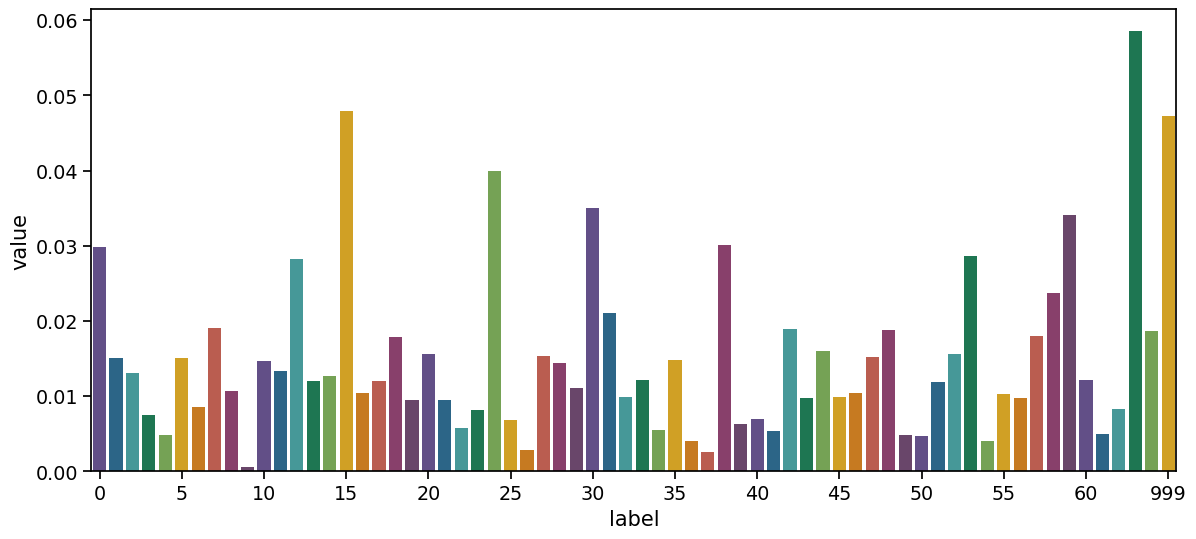

In [116]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

plt.figure(figsize=(14, 6))
ax = plt.gca()
sns.barplot(index_importances, palette=palette,ax=ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=16))

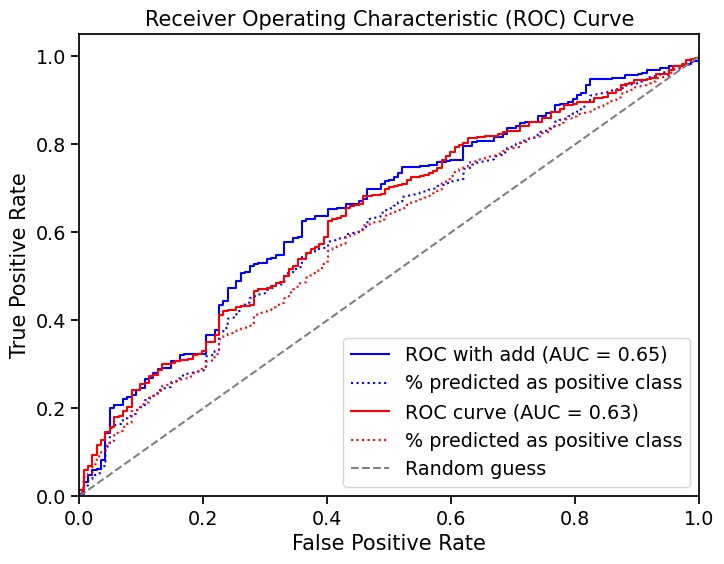

In [117]:
# compare with and without candidate measures

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba2[:, 1])
true_counts_rel = [(pred_proba2[:, 1] > thr).sum() / pred_proba2.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC with add (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### variable window generated

In [176]:
mm[mm.segment=='generated'].groupby('pid').tokzero.max().min()

14

In [120]:
%%time

outs_generated = []

for K in range(0, mm[mm.segment=='generated'].groupby('pid').tokzero.max().min()+1, 1):
    print(K, end='\r')
    ds = mm[(mm.segment=='generated') & (mm.tokzero<=K)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
    ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.merge(truth, on=['run', 'pid'])
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-2])
    
    for r in range(8):
        ds = ds.sample(frac=1)
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        pids_res = pids
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=5), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_generated.append((r, K, pred_proba, y_res))

CPU times: user 4min 2s, sys: 30.3 s, total: 4min 33s
Wall time: 38.1 s


In [121]:
%%time

outs_generated_kl = []

selected_features = list(df_logitlens_kl_expanded.columns) + list(df_logitlens_iou_expanded.columns)

for K in range(0, mmg.groupby('pid').tokzero.max().min()+1, 1):
    print(K, end='\r')
    ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<=K)][['run', 'pid', 'tokzero'] + selected_features]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()
    ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
    ds = ds.merge(truth, on=['run', 'pid'])
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-2])
    
    for r in range(8):
        ds = ds.sample(frac=1)
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        pids_res = pids
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=5), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_generated_kl.append((r, K, pred_proba, y_res))

CPU times: user 1h 7min 1s, sys: 5min 9s, total: 1h 12min 10s
Wall time: 11min 22s


In [130]:
# generated with entropy/maxp features

aucs = []
for r, K, pred_proba, y_res in outs_generated:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))
    
aucs_1 = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])
aucs_1['src'] = 'entropy/maxp'


# generated with kl/iou
aucs = []
for r, K, pred_proba, y_res in outs_generated_kl:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))
    
aucs_2 = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])
aucs_2['src'] = 'kl/iou'

# aucs_ = pd.concat([aucs_1, aucs_2], axis=1)

#from scipy.ndimage import gaussian_filter1d
#aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

#sns.lineplot(aucs_, x='k', y='auc').set_title("AUC generated 1>14")
#plt.show()

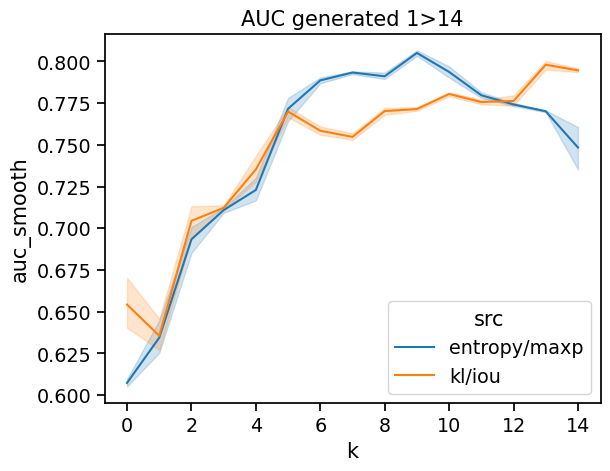

In [134]:
aucs_ = pd.concat([aucs_1, aucs_2], axis=0)

from scipy.ndimage import gaussian_filter1d
aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

sns.lineplot(aucs_, x='k', y='auc_smooth', hue='src').set_title("AUC generated 1>14")
plt.show()

### variable windows postilla

In [143]:
mm[mm.segment=='postilla'].tokzero.max()

64

In [189]:
%%time

outs_postilla = []

for K in range(0, mm[mm.segment=='postilla'].tokzero.max()+1, 2):
    print(K, end='\r')
    ds = mm[(mm.segment=='postilla') & (mm.tokzero<=K)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
    ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.merge(truth, on=['run', 'pid'])
    ds = ds[ds.pid.isin(aggrodue.pid.unique())] # something got lost on the way? 
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-2])
    
    for r in range(8):
        ds = ds.sample(frac=1)
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_postilla.append((r, K, pred_proba, y_res))

CPU times: user 1h 32s, sys: 3min 47s, total: 1h 4min 20s
Wall time: 8min 43s


In [190]:
aucs = []
for r, K, pred_proba, y_res in outs_postilla:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))

In [191]:
aucs_ = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])

In [192]:
from scipy.ndimage import gaussian_filter1d
aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

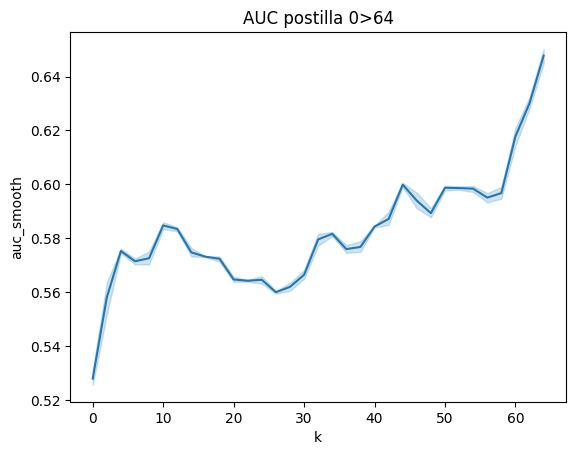

In [197]:
# postilla
sns.lineplot(aucs_, x='k', y='auc_smooth').set_title("AUC postilla 0>64")
plt.show()

In [198]:
%%time

outs_question = []

for K in range(-1, -128, -16):
    print(K, end='\r')
    ds = mm[(mm.segment=='question') & (mm.tokzero_end>=K)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
    ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp', 'true_ent']).reset_index()
    ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
    ds = ds.merge(truth, on=['run', 'pid'])
    ds = ds[ds.pid.isin(aggrodue.pid.unique())] # something got lost on the way? 
    
    # WARNING only unique observations
    ds = ds.drop_duplicates(ds.columns[1:-2])
    
    for r in range(1):
        ds = ds.sample(frac=1)
        y = ds.correct
        pids = ds.pid
        X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])
        X_res, y_res = X, y
        X_res.columns = ['generated_'+col for col in X.columns]
        
        class_counts = np.bincount(y_res)
        class_weights = {cls: class_counts.sum() / count for cls, count in enumerate(class_counts)}
        sample_weights = np.array([class_weights[y] for y in y_res])
        
        pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), 
                               groups=pids_res, method='predict_proba', fit_params={'sample_weight': sample_weights})
    
        outs_question.append((r, K, pred_proba, y_res))

CPU times: user 14min 47s, sys: 32.7 s, total: 15min 20s
Wall time: 3min 43s


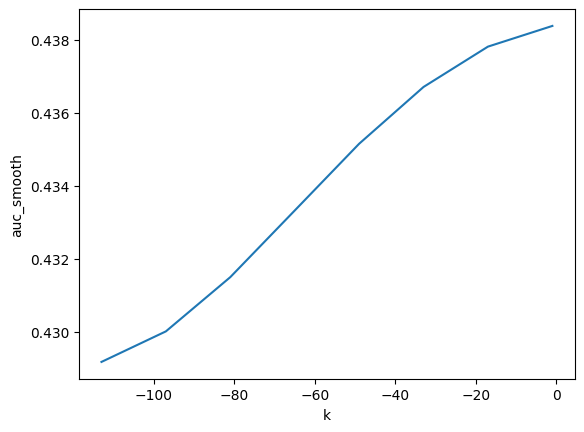

In [199]:
# end of question (reverse order)

aucs = []
for r, K, pred_proba, y_res in outs_question:
    fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
    true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
    roc_auc = auc(fpr, tpr)
    aucs.append((r, K, roc_auc))
    
aucs_ = pd.DataFrame(aucs, columns=['r', 'k', 'auc'])
from scipy.ndimage import gaussian_filter1d
aucs_['auc_smooth'] = gaussian_filter1d(aucs_.auc, sigma=3)

sns.lineplot(aucs_, x='k', y='auc_smooth').set_title("AUC question -1>-128")
plt.show()